# Chennai Floods 2015 -  a geographic analysis

On December 1–2, 2015, the Indian city of Chennai received more rainfall in 24 hours than it had seen on any day since 1901. The deluge followed a month of persistent monsoon rains that were already well above normal for the Indian state of Tamil Nadu. At least 250 people have died, several hundred have been critically injured, and thousands have been affected or displaced by the flooding that has ensued.


<img src="http://eoimages.gsfc.nasa.gov/images/imagerecords/87000/87131/india_mrg_2015335-336.gif">

The animation above provides satellite-based estimates of rainfall over southeastern India on December 1–2, accumulating in 30–minute intervals. The rainfall data come from the Integrated Multi-Satellite Retrievals for GPM (IMERG), a product of the Global Precipitation Measurement mission. The brightest shades on the maps represent rainfall totals approaching 400 millimeters (16 inches) during the 48-hour period. These regional, remotely-sensed estimates may differ from the totals measured by ground-based weather stations. According to Hal Pierce, a scientist on the GPM team at NASA’s Goddard Space Flight Center, the highest rainfall totals exceeded 500 mm (20 inches) in an area just off the southeastern coast. 

[Source: NASA http://earthobservatory.nasa.gov/IOTD/view.php?id=87131]

## Chennai Floods Explained

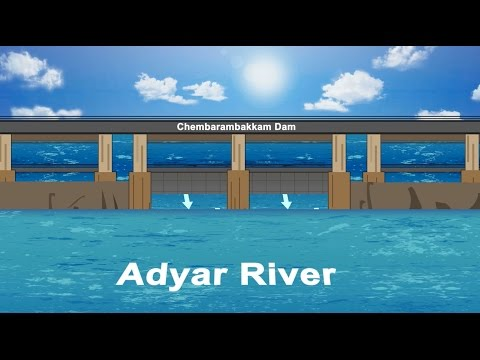

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('x4dNIfx6HVs')

The catastrophic flooding in Chennai is the result of the heaviest rain in several decades, which forced authorities to release a massive 30,000 cusecs from the Chembarambakkam reservoir into the Adyar river over two days, causing it to flood its banks and submerge neighbourhoods on both sides. It did not help that the Adyar’s stream is not very deep or wide, and its banks have been heavily encroached upon over the years.
Similar flooding triggers were in action at Poondi and Puzhal reservoirs, and the Cooum river that winds its way through the city.
While Chief Minister J Jayalalithaa said, during the earlier phase of heavy rain last month, that damage during the monsoon was “inevitable”, the fact remains that the mindless development of Chennai over the last two decades — <b>the filling up of lowlands and choking of stormwater drains and other exits for water — has played a major part in the escalation of the crisis.</b>

[Source: Indian Express http://indianexpress.com/article/explained/why-is-chennai-under-water/#sthash.LlhnqM4B.dpuf]

## How much rain and where?


To get started with our analysis, we connect to our GIS and bring in a map of the affected region. The map is a live widget that is internally using the ArcGIS JavaScript API that powers ArcGIS.com.

In [2]:
from arcgis.gis import GIS
from arcgis.lyr import FeatureCollection
from IPython.display import display

In [3]:
gis = GIS("https://deldev.maps.arcgis.com", "demo_deldev", "P@ssw0rd")

In [4]:
map = gis.map("Chennai", 8)
map

We can search for content in our GIS and add layers to our map that can be used for visualization or analysis:

<Item title:"Chennai Population" type:Feature Service owner:lisa_berry>
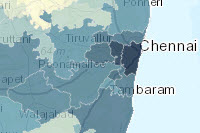

In [5]:
chennaipop = gis.content.search("Chennai Population", "feature service")[1]
chennaipop

In [6]:
map.add_layer(chennaipop)

To get a sense of how much it rained and where, let's use rainfall data for December 2nd 2015, obtained from the Regional Meteorological Center in Chennai. The data is in chennai-rainfall.csv file, that we load into a Pandas data frame, and list its contents:

In [7]:
import pandas as pd
df = pd.read_csv('chennai-rainfall.csv')
df.head()

WEATHER STATION                    LOCATION  RAINFALL
0        TAMBARAM        TAMBARAM, TAMIL NADU        49
1  CHEMBARABAKKAM  CHEMBARABAKKAM, TAMIL NADU        47
2      MARAKKANAM      MARAKKANAM, TAMIL NADU        42
3    CHENGALPATTU    CHENGALPATTU, TAMIL NADU        39
4         PONNERI         PONNERI, TAMIL NADU        39

Tabular data is hard to visualize, so let's bring in a map from our GIS to visualize the data:

In [8]:
map = gis.map("Tamil Nadu", 7)
map

We can import any Pandas data frame, with an Address field, as a layer in our GIS. We then add this layer to our map to see the locations of the weather stations from which the rainfall data was collected:

In [9]:
rainfall = gis.content.import_data(df, {"Address" : "LOCATION"})

In [10]:
map.add_layer(rainfall, { "renderer":"ClassedSizeRenderer", "field_name":"RAINFALL" })

## Spatial Analysis
Rainfall is a continuous phenonmenon that affects the whole region, not just the locations of the weather stations. Based on the observed rainfall at the monitoring stations and their locations, we can interpolate and deduce the approximate rainfall across the whole region. We use the Interpolate Points tool from the GIS's spatial analysis service for this.

The Interpolate Points tool uses <a href="http://desktop.arcgis.com/en/desktop/latest/guide-books/extensions/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm">empirical Bayesian kriging</a> to perform the interpolation:

In [11]:
interpolated_rf = gis.tools.analysis.interpolate_points(rainfall, 'RAINFALL')

In [12]:
intmap = gis.map("Tamil Nadu", 7)
intmap

In [13]:
intmap.add_layer(interpolated_rf['result_layer'])

We see that rainfall was most severe in and around Chennai as well some parts of central Tamil Nadu.

## What caused the flooding in Chennai?

### A wrong call that sank Chennai
Much of the flooding and subsequent waterlogging was a consequence of the outflows from major reservoirs into swollen rivers and into the city following heavy rains. The <b>release of waters from the Chembarambakkam reservoir</b> in particular has received much attention. [Source: The Hindu, http://www.thehindu.com/news/cities/chennai/chennai-floods-a-wrong-call-that-sank-the-city/article7967371.ece]

<img src="http://www.thehindu.com/multimedia/dynamic/02651/RedHills-graphic_j_2651019g.jpg"/>

In [14]:
lakemap = gis.map("Chennai", 11)
lakemap.height='450px'
lakemap

Let's have look at the major lakes and water reservoirs that were filled to the brim in Chennai due the rains. We plot the locations of some of the reservoirs that had a large outflow during the rains:

In [15]:
lakemap.draw(gis.tools.geocoder.find_best_match("Chembarambakkam, Tamil Nadu"), {"title": "Chembarambakkam", "content": "Water reservoir"})
lakemap.draw(gis.tools.geocoder.find_best_match("Puzhal, Tamil Nadu"), {"title": "Puzhal", "content": "Water reservoir"})
lakemap.draw(gis.tools.geocoder.find_best_match("Moovur, Tamil Nadu"), {"title": "Poondi Lake ", "content": "Water reservoir"})

To identify the flood prone areas, let's trace the path that the water would take when released from the lakes. To do this, we first bring in a layer of lakes in Chennai, and call the Trace Downstream analysis tool from the GIS:

In [16]:
chennailakes = gis.content.search("Chennai Lakes", "feature collection")[0]

<Item title:"Chennai Lakes" type:Feature Collection owner:geonuma>
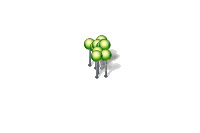

In [17]:
chennailakes

In [18]:
lakemap.add_layer(chennailakes)

In [19]:
flow_path = gis.tools.analysis.trace_downstream(chennailakes)

In [20]:
lakemap.add_layer(flow_path)

The areas surrounding the trace paths are most prone to flooding and waterlogging. To identify the areas that were at risk, we buffer the traced flow paths by one mile in each direction and visualize it on the map. We see that large areas of the city of Chennai were susceptible to flooding and waterlogging.

In [21]:
floodprone_buffer = gis.tools.analysis.create_buffers(flow_path, [ 1 ], units='Miles')

In [22]:
lakemap.add_layer(floodprone_buffer)

## Nature's fury or human made disaster?

"It is easy to attribute the devastation from unexpected flooding to the results of nature and climate change when in fact it is a result of poor planning and infrastructure. In Chennai, as in several cities across the country, we are experiencing the wanton destruction of our natural buffer zones—rivers, creeks, estuaries, marshlands, lakes—in the name of urban renewal and environmental conservation.

The recent floods in Chennai are a fallout of real estate riding roughshod over the city’s waterbodies. Facilitated by an administration that tweaked and modified building rules and urban plans, the real estate boom has consumed the city’s lakes, ponds, tanks and large marshlands.

The Ennore creek that used to be home to sprawling mangroves is fast disappearing with soil dredged from the sea being dumped there. The Kodungaiyur dump site in the Madhavaram–Manali wetlands is one of two municipal landfills that service the city. Velachery and Pallikaranai marshlands are a part of the Kovalam basin that was the southern-most of the four river basins for the city. Today, the slightest rains cause flooding and water stagnation in Velachery, home to the city’s largest mall, several other commercial and residential buildings, and also the site where low income communities were allocated land.
The <b>Pallikaranai marshlands</b>, once a site for beautiful migratory birds, are now home to the second of the two landfills in the city where the garbage is rapidly leeching into the water and killing the delicate ecosystem."

[Source: Chennai's Rain Check http://www.epw.in/commentary/chennais-rain-check.html]

There are several marshlands and mangroves in the Chennai region that act as natural buffer zones to collect rain water. Let's see the human impact on Pallikaranai marshland over the last decade by comparing satellite images.

<Item title:"Land / Water Boundary (453) 1990-2010 (Mature Support)" type:Image Service owner:esri>
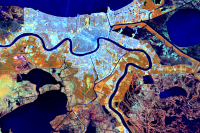

In [23]:
ls_water = gis.content.search("Land Water Boundary (453) 1990-2010", max_items=1)[0]
ls_water

In [24]:
satmap1 = gis.map("Pallikaranai, Tamil Nadu, India", 13)
display(satmap1)
satmap1.add_layer(ls_water)
satmap1.set_time_extent('1/1/1989 UTC', '1/1/1990 UTC')

In [25]:
satmap2 = gis.map("Pallikaranai, Tamil Nadu, India", 13)
display(satmap2)
satmap2.add_layer(ls_water)
satmap2.set_time_extent('1/1/2009 UTC', '1/1/2010 UTC')

The human impact on the marshland is all too apparent in the satellite images. The marshland has shrunk to less than a third of its size in just two decades.

"Not long ago, it was a 50-square-kilometre water sprawl in the southern suburbs of Chennai. Now, it is 4.3 square kilometres – less than a tenth of its original. The growing finger of a garbage dump sticks out like a cancerous tumour in the northern part of the marshland.  Two major roads cut through the waterbody with few pitifully small culverts that are not up to the job of transferring the rain water flows from such a large catchment. The edges have been eaten into by institutes like the National Institute of Ocean Technology. Ironically, NIOT is an accredited consultant to prepare Environmental Impact Assessments on various subjects, including on the implications of constructing on waterbodies.

Other portions of this wetland have been sacrificed to accommodate the IT corridor. But water offers no exemption to elite industry. Unmindful of the lofty intellectuals at work in the glass and steel buildings of the software parks, rainwater goes by habit to occupy its old haunts, bringing the back-office work of American banks to a grinding halt."

[Source: http://scroll.in/article/769928/chennai-floods-are-not-a-natural-disaster-theyve-been-created-by-unrestrained-construction]

# Flood Relief Camps

To provide emergency assistance, the Tamil Nadu government has set up several flood relief camps in the flood affected areas. They provide food, shelter and the basic necessities to thousands of people displaced by the floods. The locations of the flood relief camps was obtained from http://cleanchennai.com/floodrelief/2015/12/09/relief-centers-as-on-8-dec-2015/ and published to the GIS as a layer, that is visualized below:

In [26]:
relief_centers = gis.content.search("Chennai Relief Centers")[0]

In [27]:
reliefmap = gis.map("Chennai", 10)
reliefmap

In [28]:
reliefmap.add_layer(chennaipop)

In [29]:
reliefmap.add_layer(relief_centers)

In [30]:
relief_data = FeatureCollection(relief_centers).to_df()
relief_data.head()

Contact_No  Division____No  FID  No_of_Centres  \
0   Balamurali, 9445190311              10    1           10.0   
1    Jayakumar, 9445190302               2    2            NaN   
2    Jayakumar, 9445190302               2    3            NaN   
3    Shanmugam, 9445190301               7    4            NaN   
4  Rameshkumar, 9445190304               4    5            NaN   

   No_of_families  No_of_persons  Sl_No_ Zone_______No  \
0              65            200       1             I   
1             200            600       2           NaN   
2              75            250       3           NaN   
3              15             50       4           NaN   
4             100            300       5           NaN   

                                   _Locations  \
0                  Poonthotam School, Chennai   
1    St.Joseph church community Hall, Chennai   
2  Nehru Nagar chennai Middle school, Chennai   
3                  Kalaimagal School, Chennai   
4              Ramanathapuram School, Chennai   

   geometry.spatialReference.latestWkid  geometry.spatialReference.wkid  \
0                                  3857                          102100   
1                                  3857                          102100   
2                                  3857                          102100   
3                                  3857                          102100   
4                                  3857                          102100   

     geometry.x    geometry.y  
0  8.919695e+06  1.464333e+06  
1  8.936284e+06  1.469203e+06  
2  8.916765e+06  1.450942e+06  
3  8.924034e+06  1.462458e+06  
4  8.919695e+06  1.464333e+06

In [31]:
relief_data['No_of_persons'].sum()

31478

In [32]:
relief_data['No_of_persons'].describe()

count     136.000000
mean      231.455882
std       250.334202
min        10.000000
25%        60.000000
50%       150.000000
75%       300.000000
max      1500.000000
Name: No_of_persons, dtype: float64

In [33]:
%matplotlib inline
import matplotlib.pyplot as pd

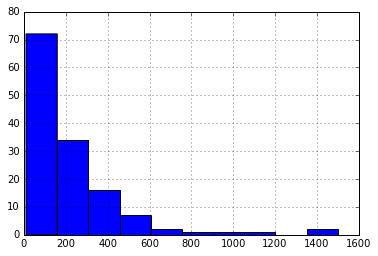

In [34]:
relief_data['No_of_persons'].hist()

In [35]:
relief_data.shape

(136, 13)

As of 8th December, 2015, there were 31,478 people in the 136 relief camps. Let's aggregate them by the district the camp is located in:

In [36]:
res = gis.tools.analysis.aggregate_points(relief_centers, chennaipop, False, ["No_of_persons Sum"])

In [37]:
aggr_lyr = res['aggregated_layer']

In [38]:
reliefmap.add_layer(aggr_lyr, { "renderer": "ClassedSizeRenderer", "field_name":"SUM_No_of_persons"})

In [39]:
df = aggr_lyr.to_df()
df2 = df[['NAME', 'SUM_No_of_persons']]
df2.set_index('NAME', inplace=True)
df2

SUM_No_of_persons
NAME                             
Sriperumbudur                3155
Tambaram                      950
Shollingalanur               1632
Chengalpattu                   49
Poonamallee                  2785
Ambattur                     1886
Chennai                     19765
Alandur                      1256

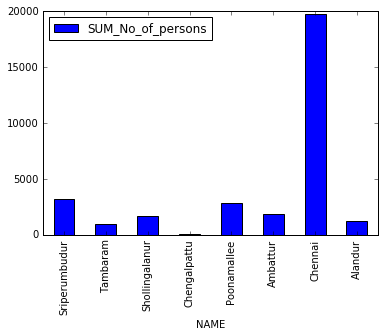

In [40]:
df2.plot(kind='bar')

## Routing Emergency Supplies to Relief Camps

A centralized center has been established at Nehru Stadium to organise the relief materials collected from various organizations and volunteers.  From there, the relief material is distributed to the needy flood affected people.

The GIS provided routing tools that can help plan routes of the relief trucks from the center to relief camps:

In [41]:
routemap = gis.map("Chennai", 12)
routemap

In [42]:
nehru_stadium = gis.tools.geocoder.find_best_match('Jawaharlal Nehru Stadium, Chennai')
routemap.draw(nehru_stadium, {"title": "Nehru Stadium", "content": "Chennai Flood Relief Center"})

In [43]:
routes = gis.tools.analysis.plan_routes(relief_centers, 15, 15, 1449984720000, nehru_stadium, stop_service_time=30)

Input field [OID] was not mapped to a field in the network analysis class "Orders".
Input field [OID] was not mapped to a field in the network analysis class "Depots".
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Avoid Unpaved Roads" "Avoid Private Roads" "Through Traffic Prohibited" "Avoid Gates").
{"messageCode": "AO_100116", "message": "Only 10 out of 15 routes are needed to reach all stops. If you want to use more routes, run Plan Routes again but reduce the limits on the maximum number of stops or the total route time per vehicle.", "params": {"routesUsed": 10, "routeCount": 15}}


In [44]:
routemap.add_layer(routes['routes_layer'])

In [45]:
routemap.add_layer(routes['assigned_stops_layer'])

Once the routes have been generated, they can be given to drivers, and used to ensure that relief material is promptly delivered to those in need and help alleviate the suffering they are going through, caused by this devastating flood.